In [116]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
!wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

--2023-04-15 11:58:51--  https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg
Resolving segment-anything.com (segment-anything.com)... 108.158.245.28, 108.158.245.33, 108.158.245.84, ...
Connecting to segment-anything.com (segment-anything.com)|108.158.245.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 221810 (217K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>] 216.61K   348KB/s    in 0.6s    

2023-04-15 11:58:53 (348 KB/s) - ‘dog.jpg’ saved [221810/221810]



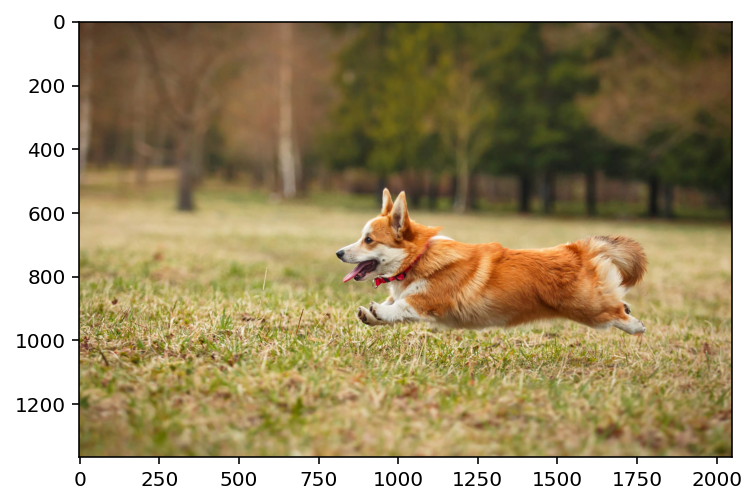

In [117]:
# Read image and convert to RGB
img = plt.imread('dog.jpg')

# Convert to [0, 1] range

img = img / 255


# Plot image
plt.imshow(img)

In [118]:
img

array([[[0.30980392, 0.20392157, 0.1372549 ],
        [0.31372549, 0.20784314, 0.14117647],
        [0.31372549, 0.20784314, 0.14117647],
        ...,
        [0.29411765, 0.21568627, 0.11764706],
        [0.29411765, 0.21568627, 0.11764706],
        [0.29803922, 0.21176471, 0.11764706]],

       [[0.30980392, 0.20392157, 0.1372549 ],
        [0.31372549, 0.20784314, 0.14117647],
        [0.31372549, 0.20784314, 0.14117647],
        ...,
        [0.29411765, 0.21568627, 0.11764706],
        [0.29411765, 0.21568627, 0.11764706],
        [0.29803922, 0.21176471, 0.11764706]],

       [[0.30980392, 0.20392157, 0.1372549 ],
        [0.31372549, 0.20784314, 0.14117647],
        [0.31372549, 0.20784314, 0.14117647],
        ...,
        [0.29411765, 0.21568627, 0.11764706],
        [0.29411765, 0.21568627, 0.11764706],
        [0.29803922, 0.21176471, 0.11764706]],

       ...,

       [[0.4745098 , 0.40392157, 0.14509804],
        [0.4745098 , 0.40392157, 0.14509804],
        [0.47843137, 0

In [119]:
from sklearn.cluster import KMeans

# Reshape image to 2D array
img_2d = img.reshape(-1, 3)


In [120]:
# Fit KMeans from scikit-learn (slow!)
kmeans = KMeans(n_clusters=5, random_state=0).fit(img_2d)

In [126]:
kmeans.cluster_centers_, kmeans.labels_

(array([[0.59260829, 0.48656705, 0.2670584 ],
        [0.24250138, 0.22963615, 0.12538282],
        [0.8270407 , 0.74152134, 0.54547183],
        [0.71622954, 0.62308534, 0.39023071],
        [0.419752  , 0.3354403 , 0.18325719]]),
 array([1, 1, 1, ..., 4, 4, 4], dtype=int32))

In [127]:
# instead use FAISS with GPU

import faiss
# Set up FAISS index
d = img_2d.shape[1]  # Dimension of the feature vectors
n_clusters = 5   # Number of clusters
n_gpus = 2         # Number of GPUs to use

# Initialize a multi-GPU IndexFlatL2 index
index_flat = faiss.IndexFlatL2(d)
index = faiss.index_cpu_to_all_gpus(index_flat, ngpu=n_gpus)

In [128]:
kmeans_gpu = faiss.Clustering(d, n_clusters)
kmeans_gpu.verbose = True
kmeans_gpu.niter = 20
kmeans_gpu.train(img_2d.astype(np.float32), index)

Sampling a subset of 1280 / 2795520 for training
Clustering 1280 points in 3D to 5 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.02 s
  Iteration 19 (0.48 s, search 0.00 s): objective=12.4307 imbalance=1.031 nsplit=0       


In [129]:
_, I = index.search(img_2d.astype(np.float32), 1)  # Search for nearest centroid
cluster_ids = I.squeeze()

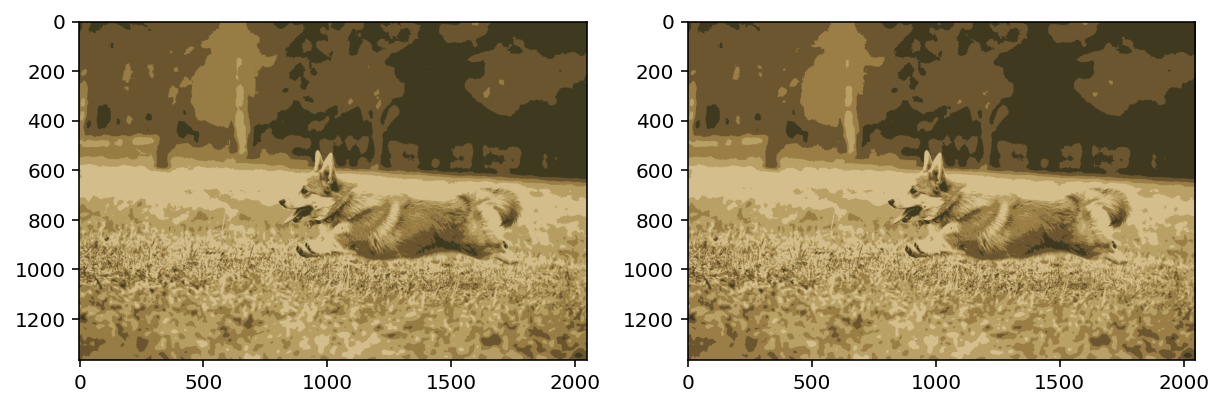

In [130]:
# Create segmented image using cluster centers frmo sklearn
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(img.shape)

centroids_gpu = faiss.vector_float_to_array(kmeans_gpu.centroids).reshape(n_clusters, d)
# Create segmented image using cluster centers from FAISS
segmented_img_faiss = centroids_gpu[cluster_ids]

# Plot segmented image side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(segmented_img)
ax[1].imshow(segmented_img_faiss.reshape(img.shape))

In [131]:
# Now, let's try to segment the image using a different number of clusters using FAISS

def segment_plot(img, k=5):
    # Reshape image to 2D array
    img_2d = img.reshape(-1, 3)

    # Set up FAISS index
    d = img_2d.shape[1]  # Dimension of the feature vectors
    n_clusters = k   # Number of clusters
    n_gpus = 2         # Number of GPUs to use

    # Initialize a multi-GPU IndexFlatL2 index
    index_flat = faiss.IndexFlatL2(d)
    index = faiss.index_cpu_to_all_gpus(index_flat, ngpu=n_gpus)

    kmeans_gpu = faiss.Clustering(d, n_clusters)
    kmeans_gpu.verbose = True
    kmeans_gpu.niter = 20
    kmeans_gpu.train(img_2d.astype(np.float32), index)

    _, I = index.search(img_2d.astype(np.float32), 1)  # Search for nearest centroid
    cluster_ids = I.squeeze()

    centroids_gpu = faiss.vector_float_to_array(kmeans_gpu.centroids).reshape(n_clusters, d)
    # Create segmented image using cluster centers from FAISS
    segmented_img_faiss = centroids_gpu[cluster_ids]

    # Plot segmented image side by side
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img)
    ax[1].imshow(segmented_img_faiss.reshape(img.shape))

    # Plot the color of each cluster
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    ax.imshow(centroids_gpu.reshape(1, n_clusters, 3))
    


Sampling a subset of 512 / 2795520 for training
Clustering 512 points in 3D to 2 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.02 s
  Iteration 19 (0.45 s, search 0.00 s): objective=14.8063 imbalance=1.000 nsplit=0       


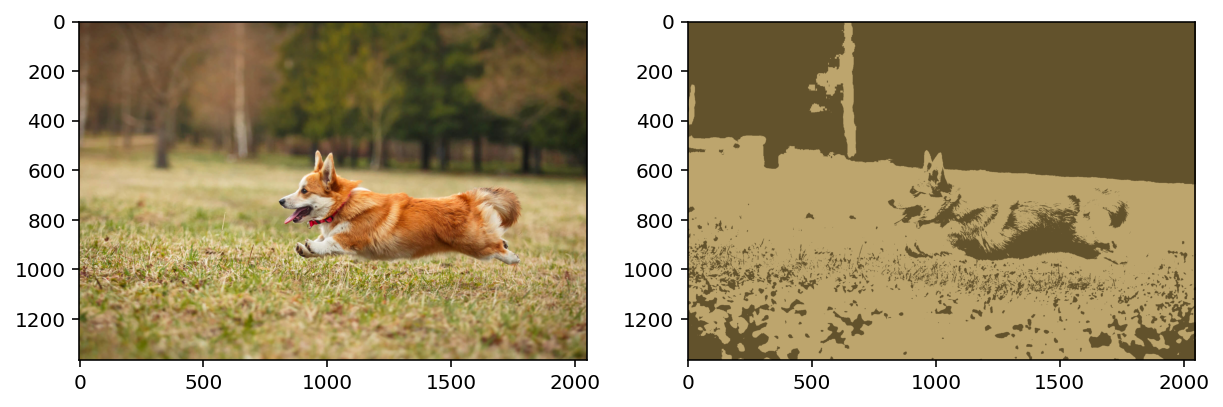

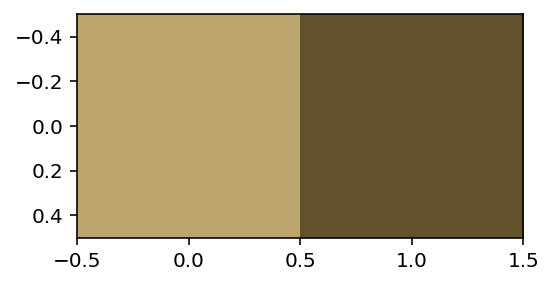

In [132]:
segment_plot(img, k=2)

Sampling a subset of 2560 / 2795520 for training
Clustering 2560 points in 3D to 10 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.02 s
  Iteration 19 (0.44 s, search 0.00 s): objective=13.6225 imbalance=1.202 nsplit=0       


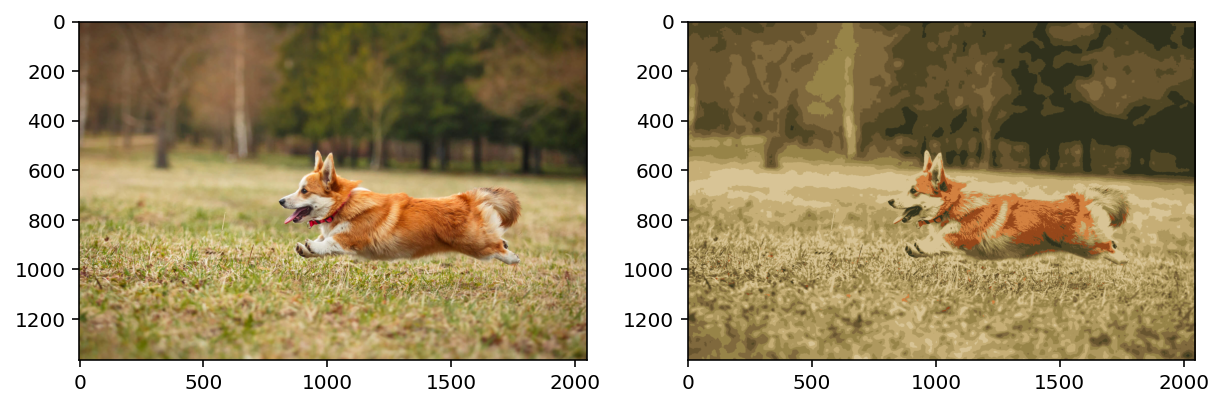

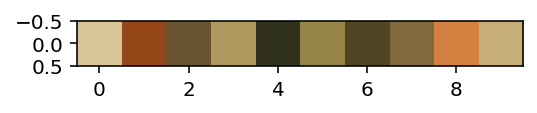

In [133]:
segment_plot(img, k=10)

Sampling a subset of 5120 / 2795520 for training
Clustering 5120 points in 3D to 20 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.02 s
  Iteration 19 (0.44 s, search 0.01 s): objective=15.3261 imbalance=1.215 nsplit=0       


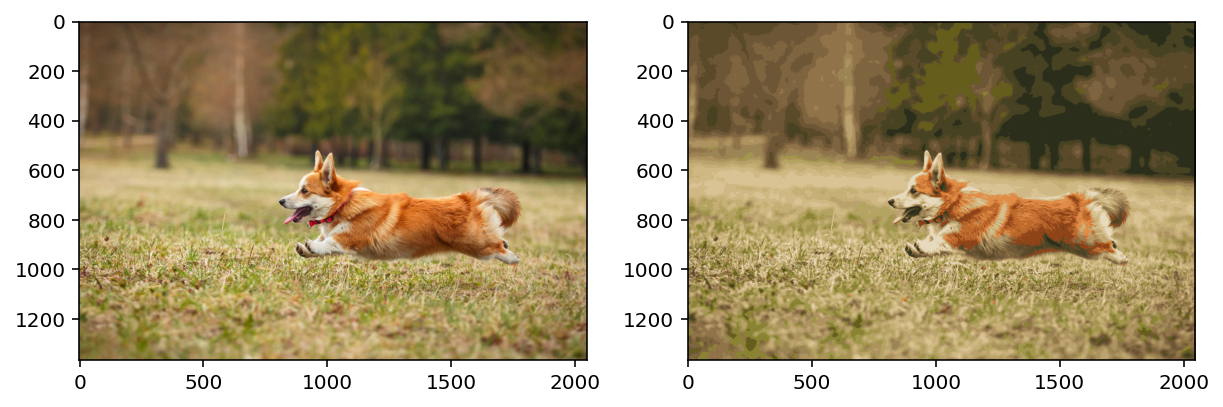

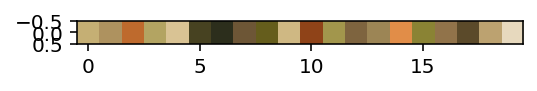

In [134]:
segment_plot(img, k=20)

In [139]:
# Modify segmentation function to mask out all but the given cluster
from copy import deepcopy
def segment_plot_mask(img, k=5, cluster_id=0):
    # Reshape image to 2D array
    img_2d = img.reshape(-1, 3)

    # Set up FAISS index
    d = img_2d.shape[1]  # Dimension of the feature vectors
    n_clusters = k   # Number of clusters
    n_gpus = 2         # Number of GPUs to use

    # Initialize a multi-GPU IndexFlatL2 index
    index_flat = faiss.IndexFlatL2(d)
    index = faiss.index_cpu_to_all_gpus(index_flat, ngpu=n_gpus)

    kmeans_gpu = faiss.Clustering(d, n_clusters)
    kmeans_gpu.verbose = True
    kmeans_gpu.niter = 20
    kmeans_gpu.train(img_2d.astype(np.float32), index)

    _, I = index.search(img_2d.astype(np.float32), 1)  # Search for nearest centroid
    cluster_ids = I.squeeze()

    centroids_gpu = faiss.vector_float_to_array(kmeans_gpu.centroids).reshape(n_clusters, d)
    # Create segmented image using cluster centers from FAISS
    segmented_img_faiss = centroids_gpu[cluster_ids]

    # Plot segmented image side by side
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax[0].imshow(img)
    segmented_img_faiss = segmented_img_faiss.reshape(img.shape)
    ax[1].imshow(segmented_img_faiss)

    
    # Now, only show the cluster we want
    mask = cluster_ids == cluster_id
    mask = mask.reshape(img.shape[:2])

    img_copy = deepcopy(segmented_img_faiss.reshape(img.shape))
    # Set all pixels that are not in the cluster to black
    img_copy[~mask] = 0

    ax[2].imshow(img_copy)
    

Sampling a subset of 512 / 2795520 for training
Clustering 512 points in 3D to 2 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.02 s
  Iteration 19 (0.04 s, search 0.00 s): objective=14.8063 imbalance=1.000 nsplit=0       


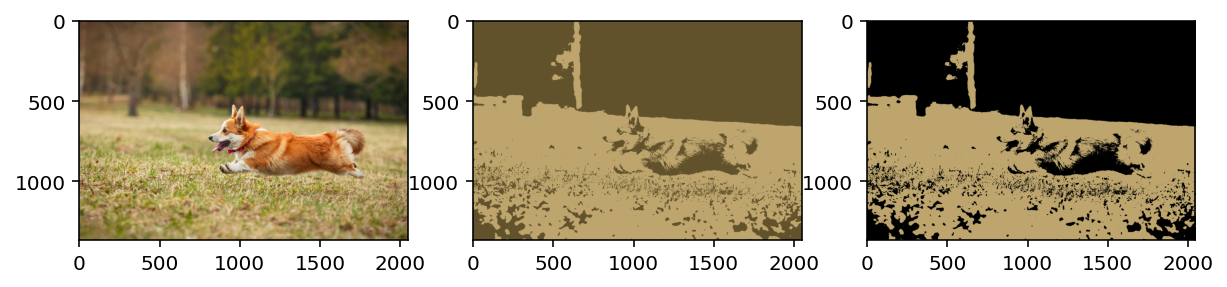

In [142]:
mask = segment_plot_mask(img, k=2, cluster_id=0)

Sampling a subset of 512 / 2795520 for training
Clustering 512 points in 3D to 2 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.02 s
  Iteration 19 (0.01 s, search 0.00 s): objective=14.8063 imbalance=1.000 nsplit=0       


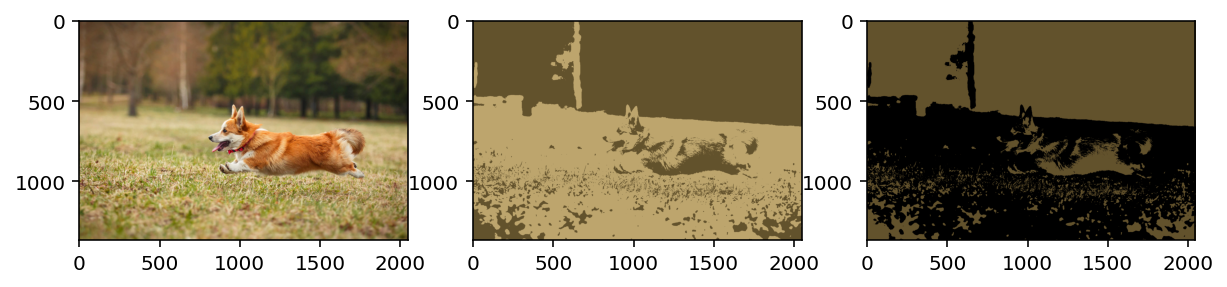

In [143]:
mask = segment_plot_mask(img, k=2, cluster_id=1)

Sampling a subset of 1024 / 2795520 for training
Clustering 1024 points in 3D to 4 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.02 s
  Iteration 19 (0.47 s, search 0.00 s): objective=12.6442 imbalance=1.031 nsplit=0       


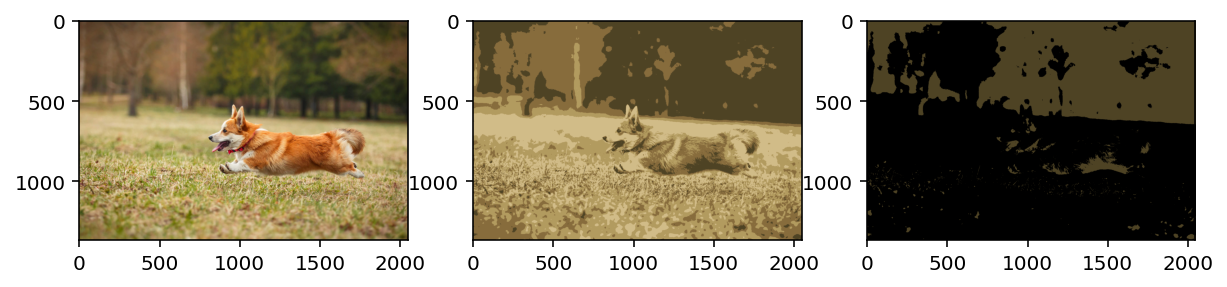

In [145]:
mask = segment_plot_mask(img, k=4, cluster_id=0)

In [146]:
# Now, let us segment the image using not only RGB but also the spatial coordinates

# Reshape image to 2D array
img_2d = img.reshape(-1, 3)

# Add spatial coordinates
x = np.arange(img.shape[0])
y = np.arange(img.shape[1])

# Let us bring the spatial coordinates to the range [0, 1] like the RGB values
x = x / x.max()
y = y / y.max()

xx, yy = np.meshgrid(x, y)
xx = xx.reshape(-1, 1)
yy = yy.reshape(-1, 1)

img_2d_spatial = np.hstack((img_2d, xx, yy))

In [147]:
# Now, modify the segment_plot function to include spatial coordinates

def segment_plot_spatial(img, k=5):
    # Reshape image to 2D array
    img_2d = img.reshape(-1, 3)

    # Add spatial coordinates
    x = np.arange(img.shape[0])
    y = np.arange(img.shape[1])

    # Normalize spatial coordinates
    x = (x - x.mean()) / x.std()
    y = (y - y.mean()) / y.std()

    xx, yy = np.meshgrid(x, y)
    xx = xx.reshape(-1, 1)
    yy = yy.reshape(-1, 1)

    img_2d_spatial = np.hstack((img_2d, xx, yy))

    # Set up FAISS index
    d = img_2d_spatial.shape[1]  # Dimension of the feature vectors
    n_clusters = k   # Number of clusters
    n_gpus = 2         # Number of GPUs to use

    # Initialize a multi-GPU IndexFlatL2 index
    index_flat = faiss.IndexFlatL2(d)
    index = faiss.index_cpu_to_all_gpus(index_flat, ngpu=n_gpus)

    kmeans_gpu = faiss.Clustering(d, n_clusters)
    kmeans_gpu.verbose = True
    kmeans_gpu.niter = 20    
    kmeans_gpu.train(img_2d_spatial.astype(np.float32), index)

    _, I = index.search(img_2d_spatial.astype(np.float32), 1)  # Search for nearest centroid
    cluster_ids = I.squeeze()

    centroids_gpu = faiss.vector_float_to_array(kmeans_gpu.centroids).reshape(n_clusters, d)
    # Create segmented image using cluster centers from FAISS with spatial coordinates excluded for plotting
    segmented_img_faiss = centroids_gpu[cluster_ids, :3]

    # Plot segmented image side by side
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img)
    ax[1].imshow(segmented_img_faiss.reshape(img.shape))

Sampling a subset of 1280 / 2795520 for training
Clustering 1280 points in 5D to 5 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.03 s
  Iteration 19 (0.42 s, search 0.00 s): objective=626.83 imbalance=1.086 nsplit=0        


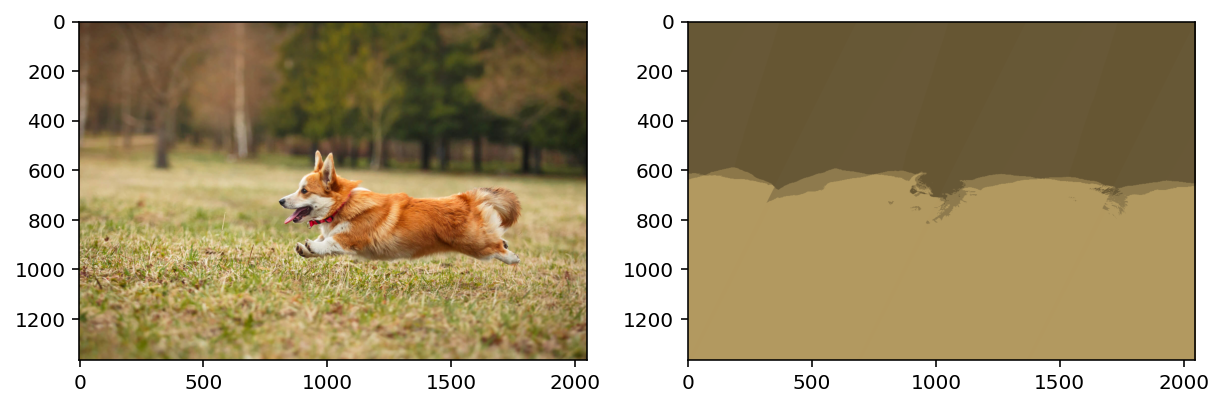

In [150]:
segment_plot_spatial(img, k=5)